In [1]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import unicodedata
import string
import os
import torch.nn as nn
import torch
import random
import time
import math
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# Preparing the data
all_letters = string.ascii_letters + " .,;'-"
n_letters = len(all_letters) + 1  # plus EOS marker


def find_files(path): return glob.glob(path)


def unicode2ascii(s):
    """
    Turn a Unicode string to plain ASCII.
    """
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )


def read_lines(filename):
    """
    Read a file and split into lines.
    """
    file_line = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicode2ascii(line) for line in file_line]


# Build the category_lines dictionary, a list of lines per category
category_lines = {}
all_categories = []
for fn in find_files('../../PyTorch/data/data/names/*.txt'):
    category = os.path.splitext(os.path.basename(fn))[0]
    all_categories.append(category)
    lines = read_lines(fn)
    category_lines[category] = lines

n_categories = len(all_categories)

if n_categories == 0:
    raise RuntimeError('Data not found. Make sure that you downloaded data '
                       'from https://download.pytorch.org/tutorial/data.zip and extract it to '
                       'the current directory.')

print('# categories:', n_categories, all_categories)
print(unicode2ascii("O'Néàl"))
print(n_letters)


# Creating the Network
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size

        self.i2h = nn.Linear(n_categories + input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(n_categories + input_size + hidden_size, output_size)
        self.o2o = nn.Linear(hidden_size + output_size, output_size)
        self.dropout = nn.Dropout(0.1)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, category_input, x, hidden):
        input_combined = torch.cat((category_input, x, hidden), 1)
        hidden = self.i2h(input_combined)
        output = self.i2o(input_combined)
        output_combined = torch.cat((hidden, output), 1)
        output = self.o2o(output_combined)
        output = self.dropout(output)
        output = self.softmax(output)
        return output, hidden

    def init_hidden(self):
        return torch.zeros(1, self.hidden_size)


# Preparing for Training
def ran_choice(l):
    """
    Random item from a list.
    """
    return l[random.randint(0, len(l) - 1)]


def ran_input():
    """
    Get a random category and random line from that category
    """
    category_sample = ran_choice(all_categories)
    line = ran_choice(category_lines[category])
    return category_sample, line


def category2tensor(category_input):
    """
    One-hot vector for category
    """
    i = all_categories.index(category_input)
    tensor = torch.zeros(1, n_categories)
    tensor[0][i] = 1
    return tensor


def input2tensor(line_input):
    """
    One-hot matrix of first to last letters (not including EOS) for input.
    """
    tensor = torch.zeros(len(line_input), 1, n_letters)
    for i in range(len(line_input)):
        letter = line_input[i]
        tensor[i][0][all_letters.find(letter)] = 1
    return tensor


def target2tensor(line_input):
    """
    LongTensor of second letter to end (EOS) for target.
    """
    letter_indexes = [all_letters.find(line_input[i]) for i in range(1, len(line_input))]
    letter_indexes.append(n_letters - 1)   # EOS
    return torch.LongTensor(letter_indexes)


def ran_sample():
    """
    Make category, input, and target tensors from a random category, line pair
    """
    category_input, line_input = ran_input()
    category_tensor = category2tensor(category_input)
    input_tensor = input2tensor(line_input)
    target_tensor = target2tensor(line_input)
    return category_tensor, input_tensor, target_tensor


# Training the Network
criterion = nn.NLLLoss()
learning_rate = 0.0005
rnn = RNN(n_letters, 128, n_letters)


def train(category_tensor, input_tensor, target_tensor):
    target_tensor.unsqueeze_(-1)
    hidden = rnn.init_hidden()

    rnn.zero_grad()

    loss = 0

    for i in range(input_tensor.size(0)):
        output, hidden = rnn(category_tensor, input_tensor[i], hidden)
        l = criterion(output, target_tensor[i])
        loss += l

    loss.backward()

    for p in rnn.parameters():
        p.data.add_(-learning_rate, p.grad.data)

    return output, loss.item() / input_tensor.size(0)


def timesince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

# categories: 18 ['Czech', 'German', 'Arabic', 'Japanese', 'Chinese', 'Vietnamese', 'Russian', 'French', 'Irish', 'English', 'Spanish', 'Greek', 'Italian', 'Portuguese', 'Scottish', 'Dutch', 'Korean', 'Polish']
O'Neal
59


In [245]:
n_iters = 100000
print_every = 5000
plot_every = 500
all_losses = []
total_loss = 0

start = time.time()

for iter in range(1, n_iters + 1):
    output, loss = train(*ran_sample())
    total_loss += loss

    if iter % print_every == 0:
        print('%s (%d %d%%) %.4f' % (timesince(start), iter, iter / n_iters * 100, loss))

    if iter % plot_every == 0:
        all_losses.append(total_loss / plot_every)
        total_loss = 0

0m 16s (5000 5%) 1.2749
0m 32s (10000 10%) 0.7785
0m 50s (15000 15%) 0.6279
1m 6s (20000 20%) 0.5893
1m 23s (25000 25%) 0.5260
1m 39s (30000 30%) 0.5238
1m 56s (35000 35%) 1.4610
2m 12s (40000 40%) 0.5210
2m 28s (45000 45%) 0.2645
2m 45s (50000 50%) 0.9852
3m 1s (55000 55%) 0.5779
3m 18s (60000 60%) 1.3027
3m 34s (65000 65%) 0.7840
3m 51s (70000 70%) 0.5558
4m 7s (75000 75%) 1.0563
4m 23s (80000 80%) 0.6924
4m 40s (85000 85%) 0.1215
4m 56s (90000 90%) 0.4168
5m 13s (95000 95%) 0.2729
5m 29s (100000 100%) 0.6456


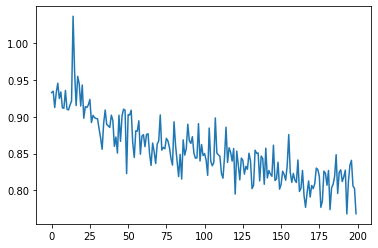

In [246]:
plt.figure()
plt.plot(all_losses)

# Sampling the Network
max_length = 20

In [4]:
def sample(category_sample, start_letter='A'):
    """
    Sample from a category and starting letter
    """
    with torch.no_grad():
        category_tensor = category2tensor(category_sample)
        input_tensor = input2tensor(start_letter)
        hidden = rnn.init_hidden()

        output_name = start_letter

        for i in range(max_length):
            output, hidden = rnn(category_tensor, input_tensor[0], hidden)
            topv, topi = output.topk(1)
            topi = topi[0][0]
            if topi == n_letters - 1:
                break
            else:
                letter = all_letters[topi]
                output_name += letter
            input_tensor = input2tensor(letter)

        return output_name


def samples(category_sample, start_letters='ABC'):
    """
    Get multiple samples from one category and multiple starting letters
    """
    for start_letter in start_letters:
        print(sample(category_sample, start_letter))

In [263]:
samples('Russian', 'RUS')

Rutkowsei
Uarek
Sokol


In [257]:
samples('Chinese', 'LLL')

Lawniczak
Lawniczak
Lasnieka


In [308]:
samples('German', 'GER')

Gorka
Earek
RudaW


In [241]:
all_categories

['Czech',
 'German',
 'Arabic',
 'Japanese',
 'Chinese',
 'Vietnamese',
 'Russian',
 'French',
 'Irish',
 'English',
 'Spanish',
 'Greek',
 'Italian',
 'Portuguese',
 'Scottish',
 'Dutch',
 'Korean',
 'Polish']

In [244]:
category2tensor('Chinese')

tensor([[0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])